<a href="https://colab.research.google.com/github/gabrielbonfim1/MTP5/blob/main/C%C3%B3pia_de_P5mt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Programa para auxiliar na solução da prova P5 da disciplina de máquinas térmicas, FEG - UNESP
##### - Feito por Gabriel Alves , Jan/2021 ano de Pandemia.

-> Importando bibliotecas necessárias para o programa


In [ ]:
import pandas as pd     # Biblioteca para importar as turbinas a gás
!pip install pyromat
import pyromat as pm    # Biblioteca de estados termodinâmicas
import math             # Funções de arredondamento
from IPython.display import display, Markdown, Math, Latex
from sympy import *
import matplotlib.pyplot as plt


-> Importando o catálogo de turbinas a gás para a variável df (DataFrame)

In [ ]:
full_table = pd.read_excel("https://github.com/gabrielbonfim1/MTP5/blob/main/TurbinasaGas.xlsx?raw=true", sheet_name="Planilha1")
pd.set_option('display.max_rows', None)

-> Como todos os exercícios anteriores do ano, vamos assumir turbina a gás utilizando Gás natural, PCI = 50000 kJ/Kg , em paridade térmica.
-> Além disso assumiremos alguns valores usados previamente. Chequem antes das prova.

In [ ]:
PCI = 50000
cpg = 1.2              #kJ/Kg   , Cp dos gases de exaustão.
Tchi = 150             #Celsius , temperatura da chaminé inicial.

-> Para utilização do programa será necessário escolher o estado de vapor vivo (temperatura e pressão), a temperatura de entrada na caldeira, e a vazão total necessária. Preencher os valores na célula a seguir.

Obs : A pressão de entrada é calculada automaticamente.

In [ ]:
P_saida =     10        #Pressão de vapor na saida da caldeira de recuperação [MPa]
T_saida =     500       #Temperatura de saida da água na caldeira (Ta) [C]
T_entrada =   30       #Temperatura de entrada da água na caldeira (Ta) [C]
mvt=          25      #vazão de vapor vivo total a ser gerado [Kg/s]

## Código do Programa:

In [ ]:
pm.config['unit_pressure'] = 'MPa'
pm.config['unit_temperature'] = 'C'
agua = pm.get('mp.H2O')

P_entrada = P_saida / (0.95**3)
hv=agua.h(T=T_saida, p=P_saida)[0]
ha=agua.h(T=T_entrada, p=P_saida)[0]
T_sat = agua.Ts(p=P_saida)[0]
hls=agua.h(p=P_saida, x=0)[0]
hvs=agua.h(p=P_saida, x=1)[0]
mg_max = mvt*(hv-ha)/(0.8*cpg*(400-150))

in_range1 = full_table['Mass Flow (kg/s)']<=mg_max
df = full_table[in_range1]
df["Status"]=""
df["No de Conjuntos"]=""
df = df.reset_index(drop=True)

for i in range(len(df)):
  keep = True

  #Características do ciclo a gás
  modelo = df.at[i,'Modelo']

  W = df.at[i,'kW']
  HR = df.at[i,'HR (kJ/KwH)']
  Pr = df.at[i,'Pressure Ratio']
  Mg = df.at[i,'Mass Flow (kg/s)']
  Tg = df.at[i,'Exaust Temp (oC)']

  mg_necessaria = mvt*(hv-ha) / (0.8*cpg*(Tg-150))
  numero_conjuntos = max(math.floor(mg_necessaria/Mg),1)
  

  mv = mvt / numero_conjuntos

  Qg = Mg*cpg*(Tg-150)
  Qa  = mv*(hv-ha)
  Qls = mv*(hv-hls)
  Qvs = mv*(hv-hvs)
  Qv  = mv*(hv-hv)

  Rend_real = Qa/Qg

  Tpp_inf = 10
  Tpp_sup = 30

  Tch_inf = Tg + ((T_sat+Tpp_inf)-Tg)*Qg/Qls
  Tch_sup = Tg + ((T_sat+Tpp_sup)-Tg)*Qg/Qls



  ## Prints
  #print(f"Modelo : {modelo} - Potência = {W}kW - Vazão de Gases = {Mg}Kg/s - Temperatura de exaustão = {Tg} °C")
  #print(f"Número de conjuntos a gás necessários : {round(mg_necessaria/Mg,2)} -> {numero_conjuntos} + QS")
  #print("")
  #print(f"Qg = {round(Qg,1)} kW")
  #print(f"Qa = {round(Qa,1)} kW")
  #print(f"Qls = {round(Qls,1)} kW")
  #print(f"Qvs = {round(Qvs,1)} kW")
  #print(f"Qv = 0 kW")
  #print("")
  #print(f"Redimento real = {round(Rend_real*100,1)}%")
  #print(f"Temperaturas de chaminé : {round(Tch_inf,1)} °C <--> {round(Tch_sup,1)}°C")
  #print("")

  if Tch_inf > 200 or Tch_sup < 100 or Tg<T_saida:
    df.at[i,'Status'] = 0
    keep = False
    #print("Temperaturas de chaminé fora do aceitável, conjunto descartado")
  else:
    if Tch_sup > 200:
      Tch_sup = 200
      Tpp_sup = ( (Tch_sup-Tg)*Qls/Qg)-T_sat+Tg
    if Tch_inf < 100:
      Tch_inf = 100
      Tpp_inf = ( (Tch_inf-Tg)*Qls/Qg)-T_sat+Tg
    #print(f"Temperaturas de chaminés corrigidas :")
    #print(f"Tch = {round(Tch_inf,1)}°C -> Tpp = {round(Tpp_inf,1)}°C")
    #print(f"Tch = {round(Tch_sup,1)}°C -> Tpp = {round(Tpp_sup,1)}°C")
    #print("")


  Fluxo_termico_gas_sup = Rend_real*Mg*cpg*(Tg-Tch_inf)
  Fluxo_termico_gas_inf = Rend_real*Mg*cpg*(Tg-Tch_sup)

  if keep:
    if Fluxo_termico_gas_inf > Qa:
      df.at[i,'Status'] = 1
      #print("Conjunto com excedente térmico, descartado.")
    elif Fluxo_termico_gas_sup < Qa:
      #print(f"Conjunto a gás com déficit térmico, mesmo com PinchPoint mínimo de {Tpp_inf} °C, necessário queima suplementar ")
      ms = (Qa-Fluxo_termico_gas_sup)/(Rend_real*PCI)
      mc = W*HR/(3600*PCI)
      proporcao = ms/mc
      #print(f"Queima de combustível = {round(mc,3)} Kg/s")
      #print(f"Queima suplementar = {round(ms,3)} Kg/s")
      #print(f"Queima suplementar representa {round(proporcao*100,1)}% da Queima de combustível")
      if proporcao>0.1:
        df.at[i,'Status'] = 2
        #print("Queima suplementar representa mais que 10% da queima total, sugerido escolher outro conjunto a gás")
      else:
        df.at[i,'No de Conjuntos']=int(numero_conjuntos)
        df.at[i,'Status'] = 3
    else:
      #print("Existe ponto ótimo de trabalho")
      Tch_final = -1* ( (Qa/(Rend_real*cpg*Mg))-Tg)
      #print(f"Temperatura de chaminé ótima : {Tch_final} °C")
      Tpp_final = ( (Tch_final-Tg)*Qls/Qg)-T_sat+Tg
      #print(f"Delta Pinch Point ótimo : {round(Tpp_final,1)} °C")
      df.at[i,'Status'] = 4
      df.at[i,'No de Conjuntos']=int(numero_conjuntos)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## Em seguidas apresentamos os Conjuntos a gás que foram aceitos com queima suplementar (Status = 3) ou sem a necessidade dela (Status = 4)

In [ ]:
status = df[(df["Status"]==3) | (df["Status"]==4)]
status = status.reset_index(drop=True)
status

,Fabricante,Modelo,Tipo,Combustível,kW,HR (kJ/KwH),Pressure Ratio,Mass Flow (kg/s),Exaust Temp (oC),Status,No de Conjuntos
0,MAN Energy Solutions SE,THM 1304-12N,MD,L/G,12000,11610,11.0,48.1,525,3,4
1,MAN Energy Solutions SE,THM 1304-12N,EG,L/G,11520,12090,11.0,48.1,525,3,4
2,MAN Energy Solutions SE,MGT6000,EG,L/G,6630,11190,15.0,26.2,505,4,9
3,Siemens Gas and Power,SGT-100,EG,L/G,5050,11914,14.0,19.5,545,4,10
4,Siemens Gas and Power,SGT-100,MD,L/G,5700,10832,14.9,19.7,543,4,10
5,Siemens Gas and Power,SGT-300,MD,L/G,9140,10174,14.5,30.5,512,3,7
6,Siemens Gas and Power,SGT-400,EG,L/G,10360,10342,16.0,33.8,508,3,6
7,Siemens Gas and Power,SGT-400,MD,L/G,10790,9931,16.0,33.8,508,3,6
8,Siemens Gas and Power,SGT-400,EG,L/G,14326,10178,18.9,44.0,540,3,4
9,Siemens Gas and Power,SGT-400,MD,L/G,14912,9774,18.9,44.0,540,3,4


## Preencha a primeira linha com o número da Turbina escolhida na tabela anterior e execute, a análise estará no fim da página

i = ?



,Fabricante,Modelo,Tipo,Combustível,kW,HR (kJ/KwH),Pressure Ratio,Mass Flow (kg/s),Exaust Temp (oC),Status,No de Conjuntos
1,MAN Energy Solutions SE,THM 1304-12N,EG,L/G,11520,12090,11.0,48.1,525,3,4


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

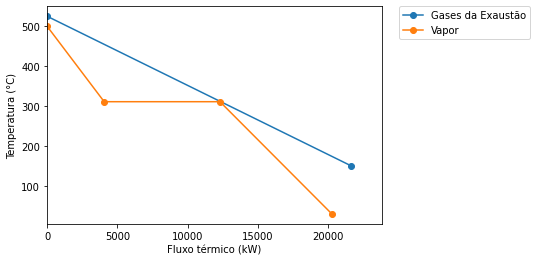

In [ ]:
i = 1

pm.config['unit_pressure'] = 'MPa'
pm.config['unit_temperature'] = 'C'
agua = pm.get('mp.H2O')
display(status.iloc[i:i+1])
print("")

P_entrada = P_saida / (0.95**3)
hv=agua.h(T=T_saida, p=P_saida)[0]
ha=agua.h(T=T_entrada, p=P_saida)[0]
T_sat = agua.Ts(p=P_saida)[0]
hls=agua.h(p=P_saida, x=0)[0]
hvs=agua.h(p=P_saida, x=1)[0]
mg_max = mvt*(hv-ha)/(0.8*cpg*(400-150))

keep = True

#Características do ciclo a gás
modelo = status.at[i,'Modelo']

W = status.at[i,'kW']
HR = status.at[i,'HR (kJ/KwH)']
Pr = status.at[i,'Pressure Ratio']
Mg = status.at[i,'Mass Flow (kg/s)']
Tg = status.at[i,'Exaust Temp (oC)']

mg_necessaria = mvt*(hv-ha) / (0.8*cpg*(Tg-150))
numero_conjuntos = int(max(math.floor(mg_necessaria/Mg),1))
mv = mvt / numero_conjuntos
print("")
display(Latex(r'\color{red}\text{Fazendo o balanço de energia com a caldeira como volume de controle:}'))
print("")
display(Latex(r'\eta_{cg}\dot{m_{g}}c_{p,g}(T_{g}-T_{ch}) = \dot{m_{v}}(h_{v}-h_{a})'))
print("")
display(Latex(r'0,8.\dot{m_{g}}.1,2(T_{g}-150) = ' + str(round(mv,2)) + '(' + str(round(hv,2)) +'-'+ str(round(ha,2)) + ')' + r'\Rightarrow\dot{m_{g}}_{necessária} = '+str(round(mg_necessaria,2))+" [kg/s]" ))
print("")
display(Latex(r'\displaystyle\frac{\dot{m_{g}}_{necessária}}{\dot{m_{g}}} = \frac{'+str(round(mg_necessaria,1))+ '}{' + str(round(Mg,1)) + '} = ' + str(round(mg_necessaria/Mg,2))+ r'\rightarrow'+ str(numero_conjuntos) + r'\mathrm{ CG + QS}'))
display(Latex(r"\text{Serão necessários "+str(numero_conjuntos)+r" CGs + Queima suplementar}"    ))
display(Latex(r'\text{---------------------------------------------------------------------------------------------------------------------------}'))


Qg = Mg*cpg*(Tg-150)
Qa  = mv*(hv-ha)
Qls = mv*(hv-hls)
Qvs = mv*(hv-hvs)
Qv  = mv*(hv-hv)

Rend_real = Qa/Qg

Tpp_inf = 10
Tpp_sup = 30

Tch_inf = Tg + ((T_sat+Tpp_inf)-Tg)*Qg/Qls
Tch_sup = Tg + ((T_sat+Tpp_sup)-Tg)*Qg/Qls



## Prints
#print(f"Modelo : {modelo} - Potência = {W}kW - Vazão de Gases = {Mg}Kg/s - Temperatura de exaustão = {Tg} °C")
#print(f"Número de conjuntos a gás necessários : {round(mg_necessaria/Mg,2)} -> {numero_conjuntos} + QS")

#display(Math(r'\dot{m_{g}} = \frac{\dot{m_{v}}.(h_{v}-h_{a})}{\eta_{cg}.c_{p,g}.(T_{g}-T_{ch})}'))
print()
display(Latex(r"\displaystyle \dot{m_{v}} = \frac{\text{Vazão total de Vapor}}{\text{Número de CGs}} = \frac{"+str(round(mvt,2))+'}{'+str(numero_conjuntos)+'} = '+str(round(mv,2))+r"\text{kg/s [ Vazão de vapor por caldeira de recuperação ]}"))
print()
display(Latex(r'\dot{Q_{g}}=\dot{m_{g}}c_{p,g}(T_{g}-T_{ch}) = '+ str(round(Mg,2)) + '*' +str(cpg) + '*' + '('+ str(round(Tg,2))+ '-' +  str(round(Tchi,2)) + ')'+str(round(Qg,1))+'kW'))
display(Latex(r'$\dot{Q_{a}}=\dot{m_{v}}(h_{v}-h_{a}) = '+ str(round(mv,2)) + '(' + str(round(hv,2)) +'-'+ str(round(ha,2))+ ') = ' +  str(round(Qa,2)) + 'kW'))
display(Latex(r'\dot{Q_{ls}}=\dot{m_{v}}(h_{v}-h_{ls}) = '+ str(round(mv,2)) + '(' + str(round(hv,2)) +'-'+ str(round(hls,2))+ ') = ' +  str(round(Qls,2)) + 'kW'))
display(Latex(r'\dot{Q_{vs}}=\dot{m_{v}}(h_{v}-h_{vs}) = '+ str(round(mv,2)) + '(' + str(round(hv,2)) +'-'+ str(round(hvs,2))+ ') = ' +  str(round(Qvs,2)) + 'kW'))
display(Latex(r'\dot{Q_{v}}=\dot{m_{v}}(h_{v}-h_{a}) = '+ str(round(mv,2)) + '(' + str(round(hv,2)) +'-'+ str(round(hv,2))+ ') = ' +  str(round(0,2)) + 'kW'))

print("")
display(Latex(r'\displaystyle \eta_{real} = \frac{Q_{a}}{Q_{g}} = \frac{'+str(round(Qa,2))+'}{'+str(round(Qg,2))+'} = ' + str(round(Rend_real,3)) +'='+str(round(Rend_real*100,1))+r"\%"   ))


display(Latex(r'\text{---------------------------------------------------------------------------------------------------------------------------}'))
print("")
display(Latex(r'\color{red}\rightarrow \text{Temperaturas de chaminé:}'))
display(Latex(r'T_{ch}= T_{g} + [(T_{sat}+\Delta T_{PP})-T_{g}] \displaystyle\frac{Q_{g}}{Q_{ls}}'))
display(Latex(r"\text{Para:}"))

if Tch_inf>100:
  display(Latex(r" \displaystyle\Delta T_{PP} = 10°C \Rightarrow T_{ch} = " +str(round(Tg,2)) + '+[(' + str(round(T_sat,1)) + '+10)-'+str(round(Tg,2))+'] '+r"\frac{"+str(round(Qg,2))+'}{'+str(round(Qls,2))+'} = '+str(round(Tch_inf))+'°C'+r'\color{green}\text{ < Ok >}'))
else:
  display(Latex(r" \displaystyle\Delta T_{PP} = 10°C \Rightarrow T_{ch} = " +str(round(Tg,2)) + '+[(' + str(round(T_sat,1)) + '+10)-'+str(round(Tg,2))+'] '+r"\frac{"+str(round(Qg,2))+'}{'+str(round(Qls,2))+'} = '+str(round(Tch_inf))+'°C'+r'\color{red}\text{ < Fora >}'))
  print()
  display(Latex(r'\rightarrow \text{        Necessária correção da temperatura de chaminé:}'))
  Tch_inf = 100
  Tpp_inf = ( (Tch_inf-Tg)*Qls/Qg)-T_sat+Tg
  print()
  display(Latex(r" \displaystyle T_{ch}' = 100°C = " +str(round(Tg,2)) + '+[(' + str(round(T_sat,1)) + r'+\Delta T_{pp})-'+str(round(Tg,2))+'] '+r"\frac{"+str(round(Qg,2))+'}{'+str(round(Qls,2))+r'}\rightarrow \Delta T_{pp}='+str(round(Tpp_inf,1))+'°C'))
print("")

if Tch_sup<200:
  display(Latex(r" \displaystyle\Delta T_{PP} = 30°C \Rightarrow T_{ch} = " +str(round(Tg,2)) + '+[(' + str(round(T_sat,1)) + '+30)-'+str(round(Tg,2))+'] '+r"\frac{"+str(round(Qg,2))+'}{'+str(round(Qls,2))+'} = '+str(round(Tch_sup))+'°C'+r'\color{green}\text{ < Ok >}'))
else:
  display(Latex(r" \displaystyle\Delta T_{PP} = 30°C \Rightarrow T_{ch} = " +str(round(Tg,2)) + '+[(' + str(round(T_sat,1)) + '+30)-'+str(round(Tg,2))+'] '+r"\frac{"+str(round(Qg,2))+'}{'+str(round(Qls,2))+'} = '+str(round(Tch_sup))+'°C'+r'\color{red}\text{ < Fora >}'))
  print()
  display(Latex(r'\rightarrow \text{        Necessária correção da temperatura de chaminé:}'))
  Tch_sup = 200
  Tpp_sup = ( (Tch_sup-Tg)*Qls/Qg)-T_sat+Tg
  print()
  display(Latex(r" \displaystyle T_{ch}' = 200°C = " +str(round(Tg,2)) + '+[(' + str(round(T_sat,1)) + r'+\Delta T_{pp})-'+str(round(Tg,2))+'] '+r"\frac{"+str(round(Qg,2))+'}{'+str(round(Qls,2))+r'}\rightarrow \Delta T_{pp}='+str(round(Tpp_sup,1))+'°C'))

display(Latex(r'\text{---------------------------------------------------------------------------------------------------------------------------}'))


Fluxo_termico_gas_sup = Rend_real*Mg*cpg*(Tg-Tch_inf)
Fluxo_termico_gas_inf = Rend_real*Mg*cpg*(Tg-Tch_sup)
display(Latex(r'\color{red}\text{Verificação de Paridade Térmica:}'))
print()
display(Latex(r"\rightarrow \text{Comparando } \eta_{CR}\dot{Q'_{g}} \text{ com } \dot{Q'_{a}} :"))
display(Latex(r"\Delta T_{pp} = "+str(round(Tpp_sup,1))+'°C' + r"\rightarrow \eta_{CR}\dot{Q'_{g}} = "+str(round(Rend_real,4))+'*'+str(round(Mg,1))+'*'+str(round(cpg,1))+'*('+str(round(Tg,1))+'-'+str(round(Tch_sup))+') = ' + str(round(Fluxo_termico_gas_inf,1))+'kW < ' +str(round(Qa,1))+'kW(='+ r"\dot{Q_{a}})\rightarrow \color{green}\text{Défict térmico}"   ))



if Fluxo_termico_gas_sup < Qa:
  display(Latex(r"\Delta T_{pp} = "+str(round(Tpp_inf,1))+'°C' + r"\rightarrow \eta_{CR}\dot{Q'_{g}} = "+str(round(Rend_real,4))+'*'+str(round(Mg,1))+'*'+str(round(cpg,1))+'*('+str(round(Tg,1))+'-'+str(round(Tch_inf))+') = ' + str(round(Fluxo_termico_gas_sup,1))+'kW < ' +str(round(Qa,1))+'kW(='+ r"\dot{Q_{a}})\rightarrow \color{green}\text{Défict térmico}"   ))
  print()
  display(Latex(r"\Rightarrow\textbf{Conjunto a gás com défict térmico, necessário Queima suplementar:}"))
  ms = (Qa-Fluxo_termico_gas_sup)/(Rend_real*PCI)
  mc = W*HR/(3600*PCI)
  proporcao = ms/mc
  print()
  display(Latex(r"\displaystyle\dot{m_{s}} = \frac{\dot{Q_{a}}-\eta_{CR}\dot{Q'_{g}}}{\eta_{CR}PCI_{s}} = \frac{" +str(round(Qa,2))+'-'+str(round(Fluxo_termico_gas_sup,1))+'}{'+str(round(Rend_real,4))+'*'+str(PCI)+'} = '+str(round(ms,4))+'kg/s'))
  print()
  display(Latex(r"\displaystyle\dot{m_{c}} = \frac{\dot{W_{liq}}HR}{3600.PCI} = \frac{"+str(round(W,0))+'*'+str(round(HR,0))+'}{3600*'+str(round(PCI,0))+'} = '+str(round(mc,4))+'kg/s'    ))
  print()
  display(Latex(r"\displaystyle \frac{\dot{m_s}}{\dot{m_{c}}} = "+str(round(proporcao*100,2))+r"\text{ \% (Ok!)}"         ))
    
else:
  display(Latex(r"\Delta T_{pp} = "+str(round(Tpp_inf,1))+'°C' + r"\rightarrow \eta_{CR}\dot{Q'_{g}} = "+str(round(Rend_real,4))+'*'+str(round(Mg,1))+'*'+str(round(cpg,1))+'*('+str(round(Tg,1))+'-'+str(round(Tch_inf))+') = ' + str(round(Fluxo_termico_gas_sup,1))+'kW > ' +str(round(Qa,1))+'kW(='+ r"\dot{Q_{a}})\rightarrow \color{red}\text{Excedente térmico}"   ))
  Tch_final = -1* ( (Qa/(Rend_real*cpg*Mg))-Tg)
  print()
  display(Latex(r"\rightarrow \text{Calculando temperatura de chaminé ótima para paridade térmica:}"))
  print()
  display(Latex(r"\dot{Q_{a}} = "+str(round(Qa,1)) + r"kW=\eta_{CR}\dot{Q'_{g}}="+str(round(Rend_real,4))+'*'+str(round(Mg,1))+'*'+str(round(cpg,1))+'('+str(round(Tg,0))+r"-T'_{ch}) \rightarrow T'_{ch}="+str(round(Tch_final,1))+'°C'))
  print()
  Tpp_final = ( (Tch_final-Tg)*Qls/Qg)-T_sat+Tg
  display(Latex(r" \displaystyle T_{ch}' ="+ str(round(Tch_final,1))+  "  = " +str(round(Tg,2)) + '+[(' + str(round(T_sat,1)) + r"+\Delta T'_{pp})-"+str(round(Tg,2))+'] '+r"\frac{"+str(round(Qg,2))+'}{'+str(round(Qls,2))+r"}\rightarrow \Delta T'_{pp}="+str(round(Tpp_final,1))+'°C'))

print()
display(Latex(r"\text{Potência total gerada }\rightarrow W_{total} = W_{cg}.Número_{cgs} =  "+str(W*numero_conjuntos)+'kW'   ))


plt.plot([0,Qg],[Tg,Tch_final],label='Gases da Exaustão',marker='o')
plt.plot([0,Qvs,Qls,Qa],[T_saida,T_sat,T_sat,T_entrada],label='Vapor',marker='o')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlim([0, 1.1*Qg])
plt.xlabel("Fluxo térmico (kW)")
plt.ylabel("Temperatura (°C)")
plt.show()
